## Azure Maintenence Prediction

https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
import pywt
from scipy.fft import fft
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

telemetry_df = pd.read_csv('telemetry.csv')
errors_df = pd.read_csv('errors.csv')

errors_df.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [2]:
errors_df.groupby('machineID').count().sort_values(ascending=False, by='errorID').head(1)

,datetime,errorID
machineID,,
22,60,60


In [3]:
telemetry_df[telemetry_df['machineID'] == 22].groupby('machineID').count()

,datetime,volt,rotate,pressure,vibration
machineID,,,,,
22,8761,8761,8761,8761,8761


In [4]:
errors_df['datetime'] = errors_df['datetime'].astype('datetime64[ns]')
telemetry_df['datetime'] = telemetry_df['datetime'].astype('datetime64[ns]')

# Selecionamos a máquina com mais ocorrências de erros
mID = 22

errors_df = errors_df[errors_df['machineID'] == mID]
telemetry_df = telemetry_df[telemetry_df['machineID'] == mID]

errors_df.drop(['machineID'], axis=1, inplace=True)
telemetry_df.drop(['machineID'], axis=1, inplace=True)

# Preprocess - qualquer erro vira 1
errors_df['error'] = errors_df['errorID'].apply(lambda x: 1)
errors_df = errors_df.drop('errorID', axis=1)

# Merge telemetry com errors pela data, e preenche com 0 as ocorrências sem erro
merged_df = telemetry_df.merge(errors_df, on=['datetime'], how='left')
merged_df['error'] = merged_df['error'].fillna(0)

In [5]:
# Janela de tempo para extrair as características
window_size = 3  
data_windows = []
labels = []

machine_data = merged_df

In [6]:
# Função para extração de características
def extract_features(window):
    features = {}
    if len(window) > 0:
        features['mean'] = window.mean()
        features['median'] = window.median()
        features['std'] = window.std()
        features['kurtosis'] = kurtosis(window)

        # Wavelet transform
        coeffs = pywt.wavedec(window, 'db1', level=1)
        features['wavelet'] = np.mean(coeffs[0])  

        # Fourier transform
        #window_np = np.array(window)
        #fourier = fft(window_np)
        #features['fourier_mean'] = np.mean(np.abs(fourier))
        #features['fourier_std'] = np.std(np.abs(fourier))
    return features

In [7]:
# Checando se as 15 horas anteriores são normais
machine_data['condition_met'] = 0

for i in range(15, len(machine_data)):
    if machine_data['error'].iloc[i-15:i].sum() == 0:
        machine_data.loc[i, 'condition_met'] = 1

In [8]:
# Sample instâncias normais 
num = 100
np.random.seed(42)
normal_indices = machine_data[(machine_data['error'] == 0) & (machine_data['condition_met'] == 1)].index
sampled_normal_indices = np.random.choice(normal_indices, size=min(num, len(normal_indices)), replace=False)
sampled_indices = sorted(list(sampled_normal_indices) + list(machine_data[machine_data['error'] == 1].index))


In [9]:
for i in sampled_indices:
    if i >= window_size and i < len(machine_data):
        window = machine_data.iloc[i-window_size:i]
        features = {}
        for column in ['volt', 'rotate', 'pressure', 'vibration']:
            column_features = extract_features(window[column])
            for key in column_features:
                features[f'{column}_{key}'] = column_features[key]
        label = machine_data.iloc[i]['error']
        data_windows.append(features)
        labels.append(label)

# Cria df com as características
feature_df = pd.DataFrame(data_windows)
feature_df['label'] = labels

In [18]:
feature_df

,volt_mean,volt_median,volt_std,volt_kurtosis,volt_wavelet,rotate_mean,rotate_median,rotate_std,rotate_kurtosis,rotate_wavelet,...,pressure_median,pressure_std,pressure_kurtosis,pressure_wavelet,vibration_mean,vibration_median,vibration_std,vibration_kurtosis,vibration_wavelet,label
0,172.178756,176.948978,16.612223,-1.5,236.965466,491.738146,523.643055,62.192745,-1.5,709.481997,...,99.023568,3.900747,-1.5,137.010933,40.809335,42.284981,3.142538,-1.5,56.437218,0.0
1,185.342348,181.359537,7.425457,-1.5,265.142605,414.337667,410.274819,32.548439,-1.5,598.120340,...,91.783887,14.121413,-1.5,139.325598,38.995313,37.379320,4.108189,-1.5,54.067783,1.0
2,178.005637,187.308564,22.077803,-1.5,242.826043,474.500488,474.876520,25.587753,-1.5,680.024456,...,107.044400,5.244126,-1.5,147.335317,38.695168,35.940844,7.489196,-1.5,57.720070,1.0
3,170.763577,173.775175,7.706687,-1.5,238.399835,450.790772,424.519342,70.059143,-1.5,628.226070,...,100.932830,6.223724,-1.5,135.512996,42.081907,42.333489,0.700639,-1.5,59.232898,0.0
4,180.083464,181.524475,15.604548,-1.5,248.922370,462.082362,418.143517,86.243624,-1.5,637.948416,...,108.377103,7.576019,-1.5,151.350158,38.828881,39.473026,1.255735,-1.5,55.140069,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,164.338753,161.059193,6.585475,-1.5,235.090494,443.222605,443.861073,34.844598,-1.5,614.380679,...,103.654409,4.125565,-1.5,144.459176,36.050764,35.188698,3.452860,-1.5,52.327765,0.0
156,168.796127,161.488424,23.672841,-1.5,248.070587,488.845680,487.994149,14.487584,-1.5,691.031129,...,95.301095,4.143129,-1.5,132.386238,42.532901,39.155426,8.959430,-1.5,57.753589,0.0
157,174.629373,170.588487,10.358080,-1.5,251.124359,496.988666,507.266800,55.535209,-1.5,706.481981,...,99.673172,3.392109,-1.5,142.564802,42.537500,40.378732,4.531853,-1.5,61.998288,1.0
158,174.612131,173.580873,2.159817,-1.5,247.816415,420.998993,417.658248,35.595997,-1.5,608.516499,...,97.160988,12.379503,-1.5,129.974054,42.620999,43.422412,1.934808,-1.5,60.772056,0.0


In [10]:
# Downsample a classe normal - para evitar que o algoritmo considere tudo como normal
sample = 100
normal_df = feature_df[feature_df['label'] == 0]
error_df = feature_df[feature_df['label'] == 1]

normal_df_downsampled = resample(normal_df, replace=False, n_samples=sample, random_state=42)
balanced_df = pd.concat([normal_df_downsampled, error_df])

# Treino e teste
X = balanced_df.drop('label', axis=1)
y = balanced_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Print metrics
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[26  4]
 [ 7 11]]
              precision    recall  f1-score   support

         0.0       0.79      0.87      0.83        30
         1.0       0.73      0.61      0.67        18

    accuracy                           0.77        48
   macro avg       0.76      0.74      0.75        48
weighted avg       0.77      0.77      0.77        48



/Users/pnferreira-m1/anaconda3/envs/koru/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using 112 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


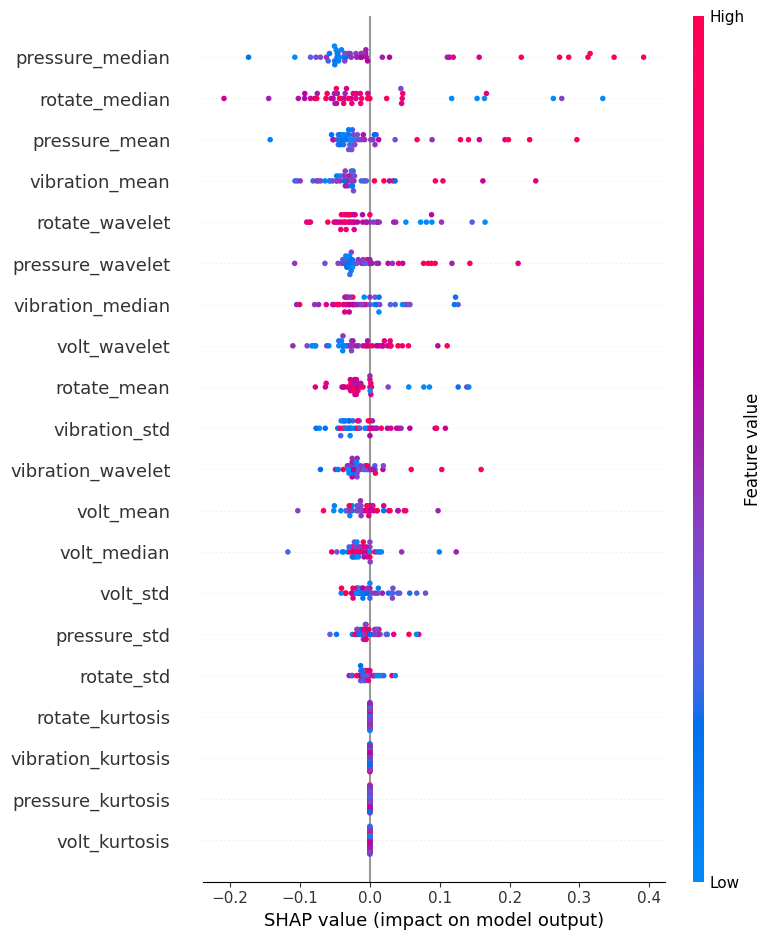

In [11]:
# Extra aula 7
import shap
explainer = shap.KernelExplainer(clf.predict, X_train)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

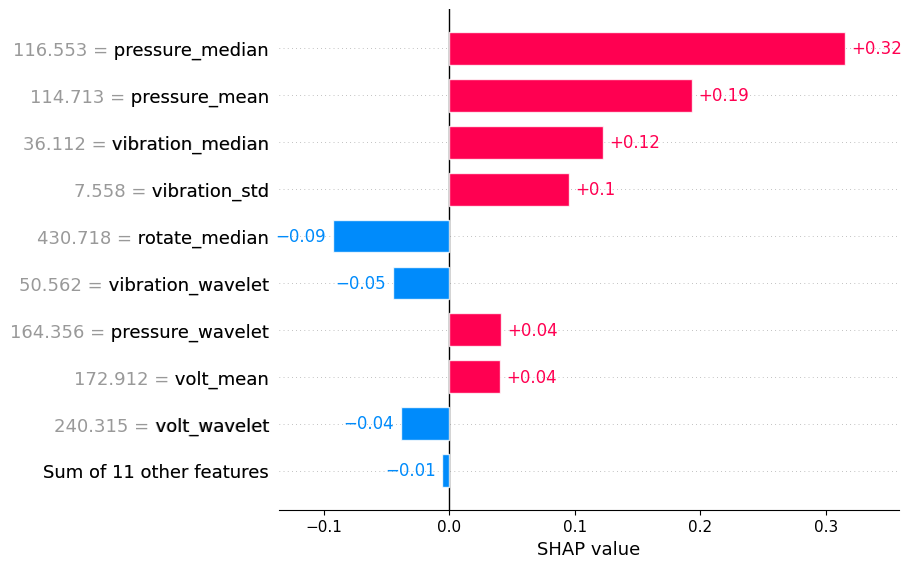

In [20]:
shap.plots.bar(shap_values[2])

In [16]:
y_test
# aula 7 fim

108    1.0
145    0.0
147    1.0
105    0.0
149    0.0
29     1.0
6      0.0
144    0.0
141    0.0
104    0.0
66     0.0
8      1.0
3      0.0
83     0.0
118    0.0
65     0.0
88     0.0
109    1.0
87     0.0
56     1.0
37     0.0
93     1.0
91     0.0
99     0.0
35     0.0
135    1.0
39     1.0
158    0.0
58     0.0
143    1.0
116    0.0
114    0.0
138    0.0
102    1.0
14     1.0
85     0.0
150    1.0
15     1.0
79     1.0
17     1.0
137    0.0
67     0.0
96     1.0
95     1.0
61     0.0
4      0.0
60     0.0
26     0.0
Name: label, dtype: float64

In [22]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

# Criar janelas de tempo para LSTM
def create_windows(df, samples_per_window, indices):
    X = []
    y = []
    for i in indices:
        if i >= samples_per_window and i < len(df):
            window = df.iloc[i-samples_per_window:i]
            X.append(window[['volt', 'rotate', 'pressure', 'vibration']].values)
            y.append(df.iloc[i]['error'])
    return np.array(X), np.array(y)

X, y = create_windows(machine_data, window_size, sampled_indices)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Teino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=42, stratify=y_categorical)

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(window_size, 4)))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, validation_split=0.1)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(confusion_matrix(y_true_classes, y_pred_classes))
print(classification_report(y_true_classes, y_pred_classes))


Epoch 1/10
4/4 [==============================] - 1s 71ms/step - loss: 0.6631 - accuracy: 0.5900 - val_loss: 0.5410 - val_accuracy: 0.7500
Epoch 2/10
4/4 [==============================] - 0s 6ms/step - loss: 0.6436 - accuracy: 0.6100 - val_loss: 0.5130 - val_accuracy: 0.7500
Epoch 3/10
4/4 [==============================] - 0s 6ms/step - loss: 0.6400 - accuracy: 0.6200 - val_loss: 0.5088 - val_accuracy: 0.8333
Epoch 4/10
4/4 [==============================] - 0s 6ms/step - loss: 0.6285 - accuracy: 0.6400 - val_loss: 0.5074 - val_accuracy: 0.8333
Epoch 5/10
4/4 [==============================] - 0s 6ms/step - loss: 0.6263 - accuracy: 0.6400 - val_loss: 0.4992 - val_accuracy: 0.7500
Epoch 6/10
4/4 [==============================] - 0s 5ms/step - loss: 0.6236 - accuracy: 0.6600 - val_loss: 0.5083 - val_accuracy: 0.7500
Epoch 7/10
4/4 [==============================] - 0s 6ms/step - loss: 0.6156 - accuracy: 0.6700 - val_loss: 0.4839 - val_accuracy: 0.8333
Epoch 8/10
4/4 [=================

## HAR - Human Activity Recognition

https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv('time_series_data_human_activities.csv')

# Convertendo para segundos
df['time'] = df['timestamp'] / 1e9

# Treino e teste
X = df[['x-axis', 'y-axis', 'z-axis']]
y = df['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest

#OBS.: Demora para rodar (2 min aqui no meu PC)! Paciência :)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

              precision    recall  f1-score   support

  Downstairs       0.32      0.13      0.19     20129
     Jogging       0.70      0.70      0.70     65138
     Sitting       0.98      0.98      0.98     12099
    Standing       0.83      0.87      0.85      9591
    Upstairs       0.35      0.15      0.21     24350
     Walking       0.60      0.77      0.67     83418

    accuracy                           0.64    214725
   macro avg       0.63      0.60      0.60    214725
weighted avg       0.60      0.64      0.61    214725

Accuracy: 0.64


In [5]:
from scipy.signal import welch
import pywt

window_size = 1  # em segundos
overlap = 0.5  # 50% overlap

# Sampling rate
sampling_rate = int(1 / (df['time'].iloc[1] - df['time'].iloc[0]))
samples_per_window = int(window_size * sampling_rate)
step_size = int(samples_per_window * (1 - overlap))

# Extração de características
def extract_features(window):
    features = {}
    for axis in ['x-axis', 'y-axis', 'z-axis']:
        # Time domain features
        features[f'{axis}_mean'] = np.mean(window[axis])
        features[f'{axis}_std'] = np.std(window[axis])
        features[f'{axis}_max'] = np.max(window[axis])
        features[f'{axis}_min'] = np.min(window[axis])
        
        # Frequency domain features using Welch's method
        #freqs, psd = welch(window[axis], fs=sampling_rate)
        #features[f'{axis}_psd_mean'] = np.mean(psd)
        #features[f'{axis}_psd_std'] = np.std(psd)
        
        # Wavelet transform features
        coeffs = pywt.wavedec(window[axis], 'db1', level=2)
        for i, coeff in enumerate(coeffs):
            features[f'{axis}_wavelet_{i}_mean'] = np.mean(coeff)
            features[f'{axis}_wavelet_{i}_std'] = np.std(coeff)
    
    return features

# Preparando o dataset
X = []
y = []

for start in range(0, len(df) - samples_per_window, step_size):
    end = start + samples_per_window
    window = df.iloc[start:end]
    if len(window) == samples_per_window:
        features = extract_features(window)
        X.append(features)
        y.append(window['activity'].mode()[0])  

X = pd.DataFrame(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
# Tempo no meu PC: 1:40
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')


              precision    recall  f1-score   support

  Downstairs       0.82      0.63      0.71      2027
     Jogging       0.96      0.99      0.97      6429
     Sitting       1.00      0.98      0.99      1163
    Standing       0.98      0.98      0.98       963
    Upstairs       0.81      0.67      0.73      2514
     Walking       0.89      0.98      0.93      8377

    accuracy                           0.91     21473
   macro avg       0.91      0.87      0.89     21473
weighted avg       0.91      0.91      0.91     21473

Accuracy: 0.91


In [7]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

# Criar janelas de tempo
def create_windows(df, samples_per_window, step_size):
    X = []
    y = []
    for start in range(0, len(df) - samples_per_window, step_size):
        end = start + samples_per_window
        window = df.iloc[start:end]
        if len(window) == samples_per_window:
            X.append(window[['x-axis', 'y-axis', 'z-axis']].values)
            y.append(window['activity'].mode()[0]) 
    return np.array(X), np.array(y)

X, y = create_windows(df, samples_per_window, step_size)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# LSTM model
# Tempo no meu PC: 2:05
model = Sequential()
model.add(LSTM(100, input_shape=(samples_per_window, 3)))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes))
print(f'Accuracy: {accuracy_score(y_true_classes, y_pred_classes):.2f}')


Epoch 1/10
1074/1074 [==============================] - 12s 11ms/step - loss: 0.4832 - accuracy: 0.8290 - val_loss: 0.2999 - val_accuracy: 0.8941
Epoch 2/10
1074/1074 [==============================] - 11s 10ms/step - loss: 0.2577 - accuracy: 0.9112 - val_loss: 0.2347 - val_accuracy: 0.9183
Epoch 3/10
1074/1074 [==============================] - 11s 10ms/step - loss: 0.1972 - accuracy: 0.9330 - val_loss: 0.1897 - val_accuracy: 0.9360
Epoch 4/10
1074/1074 [==============================] - 11s 10ms/step - loss: 0.1636 - accuracy: 0.9454 - val_loss: 0.1697 - val_accuracy: 0.9445
Epoch 5/10
1074/1074 [==============================] - 11s 10ms/step - loss: 0.1405 - accuracy: 0.9537 - val_loss: 0.1557 - val_accuracy: 0.9491
Epoch 6/10
1074/1074 [==============================] - 11s 10ms/step - loss: 0.1249 - accuracy: 0.9592 - val_loss: 0.1390 - val_accuracy: 0.9547
Epoch 7/10
1074/1074 [==============================] - 10s 10ms/step - loss: 0.1136 - accuracy: 0.9623 - val_loss: 0.1405 -